# AUC-like fairness metric

## Análise Inicial

In [4]:
import re
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from numpy import trapz
# from pprint import pprint
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.inspection import permutation_importance
from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn import metrics
# from sklearn.cluster import MiniBatchKMeans
from imblearn import FunctionSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, SVMSMOTE, BorderlineSMOTE
# from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
# from imblearn.under_sampling import TomekLinks, AllKNN, EditedNearestNeighbours, RepeatedEditedNearestNeighbours
# from imblearn.under_sampling import CondensedNearestNeighbour, NeighbourhoodCleaningRule, OneSidedSelection
# from imblearn.under_sampling import InstanceHardnessThreshold
from imblearn.pipeline import make_pipeline
# from imblearn.under_sampling import ClusterCentroids
import optuna
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay, roc_auc_score, balanced_accuracy_score
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
from pdpbox import pdp
import optuna.logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

import openai 


%matplotlib inline


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [5]:
df = pd.read_csv("/Users/larissaokabayashi/Documents/IC/NotebooksCredit/german_raw.csv",delimiter=',')
df.head().T

,0,1,2,3,4
GoodCustomer,1,-1,1,1,-1
Gender,Male,Female,Male,Male,Male
ForeignWorker,0,0,0,0,0
Single,1,0,1,1,1
Age,67,22,49,45,53
LoanDuration,6,48,12,42,24
PurposeOfLoan,Electronics,Electronics,Education,Furniture,NewCar
LoanAmount,1169,5951,2096,7882,4870
LoanRateAsPercentOfIncome,4,2,2,2,3
YearsAtCurrentHome,4,2,3,4,4


In [6]:
df.columns

Index(['GoodCustomer', 'Gender', 'ForeignWorker', 'Single', 'Age',
       'LoanDuration', 'PurposeOfLoan', 'LoanAmount',
       'LoanRateAsPercentOfIncome', 'YearsAtCurrentHome',
       'NumberOfOtherLoansAtBank', 'NumberOfLiableIndividuals', 'HasTelephone',
       'CheckingAccountBalance_geq_0', 'CheckingAccountBalance_geq_200',
       'SavingsAccountBalance_geq_100', 'SavingsAccountBalance_geq_500',
       'MissedPayments', 'NoCurrentLoan', 'CriticalAccountOrLoansElsewhere',
       'OtherLoansAtBank', 'OtherLoansAtStore', 'HasCoapplicant',
       'HasGuarantor', 'OwnsHouse', 'RentsHouse', 'Unemployed',
       'YearsAtCurrentJob_lt_1', 'YearsAtCurrentJob_geq_4',
       'JobClassIsSkilled'],
      dtype='object')

In [7]:
df.shape

(1000, 30)

In [8]:
df.describe()

,GoodCustomer,ForeignWorker,Single,Age,LoanDuration,LoanAmount,LoanRateAsPercentOfIncome,YearsAtCurrentHome,NumberOfOtherLoansAtBank,NumberOfLiableIndividuals,HasTelephone,CheckingAccountBalance_geq_0,CheckingAccountBalance_geq_200,SavingsAccountBalance_geq_100,SavingsAccountBalance_geq_500,MissedPayments,NoCurrentLoan,CriticalAccountOrLoansElsewhere,OtherLoansAtBank,OtherLoansAtStore,HasCoapplicant,HasGuarantor,OwnsHouse,RentsHouse,Unemployed,YearsAtCurrentJob_lt_1,YearsAtCurrentJob_geq_4,JobClassIsSkilled
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,0.400000,0.037000,0.54800,35.546000,20.903000,3271.258000,2.973000,2.845000,1.407000,1.155000,0.404000,0.332000,0.063000,0.214000,0.111000,0.912000,0.049000,0.293000,0.13900,0.0,0.041000,0.052000,0.713000,0.179000,0.062000,0.172000,0.42700,0.778000
std,0.916974,0.188856,0.49794,11.375469,12.058814,2822.736876,1.118715,1.103718,0.577654,0.362086,0.490943,0.471167,0.243085,0.410332,0.314289,0.283437,0.215976,0.455366,0.34612,0.0,0.198389,0.222138,0.452588,0.383544,0.241276,0.377569,0.49489,0.415799
min,-1.000000,0.000000,0.00000,19.000000,4.000000,250.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,-1.000000,0.000000,0.00000,27.000000,12.000000,1365.500000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
50%,1.000000,0.000000,1.00000,33.000000,18.000000,2319.500000,3.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,1.000000
75%,1.000000,0.000000,1.00000,42.000000,24.000000,3972.250000,4.000000,4.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.00000,1.000000
max,1.000000,1.000000,1.00000,75.000000,72.000000,18424.000000,4.000000,4.000000,4.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


In [9]:
df.isna().sum().sum()

0

In [10]:
df.NumberOfLiableIndividuals.value_counts()

1    845
2    155
Name: NumberOfLiableIndividuals, dtype: int64

In [11]:
df.Gender.value_counts()
# df.PurposeOfLoan.value_counts()

Male      690
Female    310
Name: Gender, dtype: int64

In [12]:
cost_matrix = {0:1, 1:5}
threshold = 0.5
alpha = 1

### Encoding

In [13]:
df_encoder = df.copy()

In [14]:
df_encoder.GoodCustomer.value_counts()

 1    700
-1    300
Name: GoodCustomer, dtype: int64

In [15]:
# -1 mal pagador
df_encoder.rename(columns={'GoodCustomer':'TARGET','Gender':'CODE_GENDER'},inplace=True)

df_encoder.TARGET = list(map(lambda x: 1 if x == -1 else  0 ,df_encoder.TARGET))

df_encoder.TARGET.value_counts()

0    700
1    300
Name: TARGET, dtype: int64

In [16]:
df_encoder.CODE_GENDER.value_counts()[1]/(df_encoder.CODE_GENDER.value_counts()[0] + 
                                          df_encoder.CODE_GENDER.value_counts()[1])

0.31

In [17]:
cat_cols = df_encoder.loc[:,(df_encoder.dtypes == object).values].columns # selecionadas apenas Gender e PurposeOfLoan
num_cols = df_encoder.loc[:,(df_encoder.dtypes == 'int64')|(df_encoder.dtypes == float)].columns # selecionadas as variáveis numéricas não categóricas 

In [18]:
from sklearn.preprocessing import LabelEncoder
# Male == 1/ Female == 0
# 'Electronics' = 2, 'Education' = 1, 'Furniture' = 3, 'NewCar' = 5, 'UsedCar' = 9, 'Business' = 0, 'HomeAppliances' = 4, 'Repairs' = 7, 'Other' = 6, 'Retraining'= 8
label_encoder = LabelEncoder()
for col in cat_cols:
    df_encoder[col] = label_encoder.fit_transform(df_encoder[col])

In [19]:
df["PurposeOfLoan"].unique()

array(['Electronics', 'Education', 'Furniture', 'NewCar', 'UsedCar',
       'Business', 'HomeAppliances', 'Repairs', 'Other', 'Retraining'],
      dtype=object)

In [20]:
df_encoder["PurposeOfLoan"].unique()

array([2, 1, 3, 5, 9, 0, 4, 7, 6, 8])

In [21]:
df_encoder.head()

,TARGET,CODE_GENDER,ForeignWorker,Single,Age,LoanDuration,PurposeOfLoan,LoanAmount,LoanRateAsPercentOfIncome,YearsAtCurrentHome,NumberOfOtherLoansAtBank,NumberOfLiableIndividuals,HasTelephone,CheckingAccountBalance_geq_0,CheckingAccountBalance_geq_200,SavingsAccountBalance_geq_100,SavingsAccountBalance_geq_500,MissedPayments,NoCurrentLoan,CriticalAccountOrLoansElsewhere,OtherLoansAtBank,OtherLoansAtStore,HasCoapplicant,HasGuarantor,OwnsHouse,RentsHouse,Unemployed,YearsAtCurrentJob_lt_1,YearsAtCurrentJob_geq_4,JobClassIsSkilled
0,0,1,0,1,67,6,2,1169,4,4,2,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,1
1,1,0,0,0,22,48,2,5951,2,2,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
2,0,1,0,1,49,12,1,2096,2,3,1,2,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0
3,0,1,0,1,45,42,3,7882,2,4,1,2,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1
4,1,1,0,1,53,24,5,4870,3,4,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [22]:
df.head()

,GoodCustomer,Gender,ForeignWorker,Single,Age,LoanDuration,PurposeOfLoan,LoanAmount,LoanRateAsPercentOfIncome,YearsAtCurrentHome,NumberOfOtherLoansAtBank,NumberOfLiableIndividuals,HasTelephone,CheckingAccountBalance_geq_0,CheckingAccountBalance_geq_200,SavingsAccountBalance_geq_100,SavingsAccountBalance_geq_500,MissedPayments,NoCurrentLoan,CriticalAccountOrLoansElsewhere,OtherLoansAtBank,OtherLoansAtStore,HasCoapplicant,HasGuarantor,OwnsHouse,RentsHouse,Unemployed,YearsAtCurrentJob_lt_1,YearsAtCurrentJob_geq_4,JobClassIsSkilled
0,1,Male,0,1,67,6,Electronics,1169,4,4,2,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,1
1,-1,Female,0,0,22,48,Electronics,5951,2,2,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
2,1,Male,0,1,49,12,Education,2096,2,3,1,2,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0
3,1,Male,0,1,45,42,Furniture,7882,2,4,1,2,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1
4,-1,Male,0,1,53,24,NewCar,4870,3,4,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [23]:
df_encoder.TARGET.value_counts()

0    700
1    300
Name: TARGET, dtype: int64

In [24]:
target_column_name = 'TARGET'
sensitive_column_name = 'CODE_GENDER'
pos_label = 0

In [25]:
df_encoder.CODE_GENDER.unique()

array([1, 0])

In [26]:
df_encoder.iloc[618]

TARGET                                1
CODE_GENDER                           0
ForeignWorker                         0
Single                                0
Age                                  21
LoanDuration                         30
PurposeOfLoan                         3
LoanAmount                         3441
LoanRateAsPercentOfIncome             2
YearsAtCurrentHome                    4
NumberOfOtherLoansAtBank              1
NumberOfLiableIndividuals             1
HasTelephone                          0
CheckingAccountBalance_geq_0          1
CheckingAccountBalance_geq_200        0
SavingsAccountBalance_geq_100         1
SavingsAccountBalance_geq_500         0
MissedPayments                        1
NoCurrentLoan                         0
CriticalAccountOrLoansElsewhere       0
OtherLoansAtBank                      0
OtherLoansAtStore                     0
HasCoapplicant                        1
HasGuarantor                          0
OwnsHouse                             0


## Métricas

In [27]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
# import pandas as pd

def get_metrics(name_model_dict, X, y, threshold=0.5):
    models_dict = {}
    for name, model in name_model_dict.items():
        if isinstance(model, list):
            model_obj = model[0]
            y_prob = model_obj.predict_proba(X)[:, 1]
            y_pred = (y_prob >= threshold).astype('int')
        else:
            model_obj = model
            y_prob = model_obj.predict_proba(X)[:, 1]
            y_pred = (y_prob >= threshold).astype('int')

        models_dict[name] = (y_pred, y_prob)

    def get_metrics_df(models_dict, y_true):
        metrics_dict = {
            "Overall AUC": (
                lambda x: roc_auc_score(y_true, x), False),
            "Balanced Accuracy": (
                lambda x: balanced_accuracy_score(y_true, x), True),
            "Accuracy": (
                lambda x: accuracy_score(y_true, x), True),
            "Precision": (
                lambda x: precision_score(y_true, x), True),
            "Recall": (
                lambda x: recall_score(y_true, x), True),
            "F1": (
                lambda x: f1_score(y_true, x), True),
            "Specificity": (
                lambda x: recall_score(y_true, x, pos_label=0), True),
            "Sensitivity": (
                lambda x: recall_score(y_true, x, pos_label=1), True),
                " ------": (lambda x: "", True),
        }
        df_dict = {}
        for metric_name, (metric_func, use_preds) in metrics_dict.items():
            df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores)
                                    for model_name, (preds, scores) in models_dict.items()]
        return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

    return get_metrics_df(models_dict, y)

In [28]:
# Métricas de Desempenho
auc_dict = {}
acc_balanced_dict = {}
accuracy_dict = {}
precision_dict = {}
recall_dict = {}
f1_dict = {}
dict_model = {}

### Division TTV 

In [29]:
X, y = df_encoder.drop(columns=[target_column_name]),df_encoder[target_column_name]
X_train, x_aux, y_train, y_aux = train_test_split(X, y, random_state=42,test_size=0.4)
x_test, x_val, y_test, y_val = train_test_split(x_aux,y_aux,test_size=0.50, random_state=42)

## Logistic Regression

### Tunning

In [30]:
# def objective_RegLog(trial):

#     # Definindo os hiperparâmetros a serem otimizados
   
#     penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
#     C = trial.suggest_float('C', 1e-5, 1e5)
#     solver = trial.suggest_categorical('solver',["liblinear"])
#     max_iter= 1000  # Número máximo de iterações
    
#     clf = LogisticRegression(penalty=penalty, C=C, class_weight=cost_matrix, random_state=42, 
#                              max_iter=max_iter,solver=solver)
#     # Instanciando e treinando o modelo de Regressão Logística
#     clf.fit(X_train, y_train)
#     y_prob = clf.predict_proba(x_val)[:, 1]
#     preds = (y_prob >= threshold ).astype('int')
#     bal_acc = balanced_accuracy_score(y_val, preds)
#     return bal_acc

# # Criando um objeto de estudo do Optuna
# study_lr = optuna.create_study(direction='maximize')

# # Otimizando os hiperparâmetros com o método 'objective' definido acima
# study_lr.optimize(objective_RegLog, n_trials=1000)
# study_dict = study_lr.best_params

# caminho_arquivo = '/home/thalita/Documents/pos-doc/input/German/'
# nome_arquivo = 'German_Trials_Reg.csv'
# # Exportar para um arquivo CSV
# trials_df = study_lr.trials_dataframe()
# trials_df.to_csv(caminho_arquivo + nome_arquivo, index=False)

# # Printando os melhores hiperparâmetros e o valor da métrica acc_balanced associado
# print(study_lr.best_params)
# print("Best Balanced Acc: ",study_lr.best_value)

In [31]:
study_dict = {'penalty': 'l2', 'C': 44368.80029639593, 'solver': 'liblinear'}
# Best Balanced Acc:  0.6304075235109717

### Fit, Test, Validation

In [32]:
lr = LogisticRegression(max_iter=1000,penalty= study_dict['penalty'], C=study_dict['C'], class_weight=cost_matrix, solver=study_dict['solver'],random_state=42)
lr.fit(X_train, y_train)

LogisticRegression(C=44368.80029639593, class_weight={0: 1, 1: 5},
                   max_iter=1000, random_state=42, solver='liblinear')

In [33]:
# Modelo de Validação 

y_prob = lr.predict_proba(x_val)[:,1]
y_pred = (y_prob >= threshold).astype('int')

balanced_accuracy_score(y_val,y_pred)

0.5796238244514107

In [34]:
# Modelo de Teste

y_prob = lr.predict_proba(x_test)[:,1]
y_pred = (y_prob >= threshold).astype('int')

dict_model['LR'] = [lr, 0]

balanced_accuracy_score(y_test,y_pred)

0.6853203568532036

In [35]:
get_metrics(dict_model,x_test,y_test)

,LR
Overall AUC,0.732128
Balanced Accuracy,0.68532
Accuracy,0.61
Precision,0.440945
Recall,0.888889
F1,0.589474
Specificity,0.481752
Sensitivity,0.888889
------,


## Random Forest

### Tunning

In [36]:
# def objective_rf(trial):

#     # Definição dos Hiperparâmetros a serem otimizados
#     n_estimators = trial.suggest_int('n_estimators', 50, 200)
#     max_depth = trial.suggest_int('max_depth', 2, 30)
#     min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
#     min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
#     max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    
#     # Definição da Técnica
#     clf = RandomForestClassifier(
#         n_estimators=n_estimators,
#         max_depth=max_depth,
#         min_samples_split=min_samples_split,
#         min_samples_leaf=min_samples_leaf,
#         max_features=max_features,
#         random_state=42
#     )
#     # Métricas 
#     clf.fit(X_train, y_train)
#     y_prob = clf.predict_proba(x_val)[:,1]
#     preds = (y_prob>= threshold).astype('int')
#     bal_acc = balanced_accuracy_score(y_val,preds)

#     return bal_acc

# # Métodos
# # Criando um objeto de estudo do Optuna
# study_rf = optuna.create_study(direction='maximize')

# # Otimizando os hiperparâmetros com o método 'objective' definido acima
# study_rf.optimize(objective_rf, n_trials=2000)
# study_dict = study_rf.best_params
# # Obter um DataFrame dos trials
# trials_df = study_rf.trials_dataframe()

# caminho_arquivo = '/home/thalita/Documents/pos-doc/input/German/'
# nome_arquivo = 'German_Trials_RF.csv'
# # Exportar para um arquivo CSV
# trials_df.to_csv(caminho_arquivo + nome_arquivo, index=False)

# # Printando os melhores hiperparâmetros e o valor da métrica acc_balanced associado
# print(study_rf.best_params)
# print("Best Balanced Acc: ",study_rf.best_value)

In [37]:
study_dict = {'n_estimators': 78, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}

### Fit, Test, Validation

In [38]:
rf = RandomForestClassifier(
        n_estimators=study_dict['n_estimators'], max_depth=study_dict['max_depth'], 
        min_samples_split=study_dict['min_samples_split'], 
        min_samples_leaf=study_dict['min_samples_leaf'],
        random_state=42,
        class_weight=cost_matrix
    )
rf.fit(X_train,y_train)

RandomForestClassifier(class_weight={0: 1, 1: 5}, max_depth=19, n_estimators=78,
                       random_state=42)

In [39]:
# Modelo de Validação 

y_prob = rf.predict_proba(x_val)[:,1]
y_pred = (y_prob >= threshold).astype('int')

balanced_accuracy_score(y_val,y_pred)

0.6065830721003135

In [40]:
# Modelo de Teste

y_prob = rf.predict_proba(x_test)[:,1]
y_pred = (y_prob >= threshold).astype('int')

balanced_accuracy_score(y_test,y_pred)

0.5782643957826439

In [41]:
dict_model['RF'] = [rf, 0]
get_metrics(dict_model,x_test,y_test)

,LR,RF
Overall AUC,0.732128,0.733577
Balanced Accuracy,0.68532,0.578264
Accuracy,0.61,0.71
Precision,0.440945,0.608696
Recall,0.888889,0.222222
F1,0.589474,0.325581
Specificity,0.481752,0.934307
Sensitivity,0.888889,0.222222
------,,


## XGBOOST

### Tunning

In [42]:
# def objective_xg(trial):

#     # Definição dos Hiperparâmetros a serem otimizados
#     params = {
#         'objective': 'binary:logistic',
#         'eval_metric': 'logloss',
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'gamma': trial.suggest_float('gamma', 0.0, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
#         'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10.0),
#     }
#     # Definição da Técnica
#     clf =  xgb.XGBClassifier(**params,random_state= 42)
#     # Métricas 
#     clf.fit(X_train, y_train)
#     y_prob = clf.predict_proba(x_val)[:,1]
#     preds = (y_prob>= threshold).astype('int')
#     bal_acc = balanced_accuracy_score(y_val,preds)

#     return bal_acc

# # Métodos
# # Criando um objeto de estudo do Optuna
# study_xg = optuna.create_study(direction='maximize')

# # Otimizando os hiperparâmetros com o método 'objective' definido acima
# study_xg.optimize(objective_xg, n_trials=2000)
# study_dict = study_xg.best_params
# # Obter um DataFrame dos trials
# trials_df = study_xg.trials_dataframe()

# caminho_arquivo = '/home/thalita/Documents/pos-doc/input/German/'
# nome_arquivo = 'German_Trials_xg.csv'
# # Exportar para um arquivo CSV
# trials_df.to_csv(caminho_arquivo + nome_arquivo, index=False)

# # Printando os melhores hiperparâmetros e o valor da métrica acc_balanced associado
# print(study_xg.best_params)
# print("Best Balanced Acc: ",study_xg.best_value)

In [43]:
study_dict = {'learning_rate': 0.08730015238141663, 'max_depth': 8, 'subsample': 0.9885334531348575, 
              'colsample_bytree': 0.8860893884596323, 'gamma': 0.38560298254941716, 
              'reg_alpha': 0.44299387597591205, 'reg_lambda': 0.37110498550700155, 
              'min_child_weight': 0.9339053330213946}

### Fit, Test, Validation

In [44]:
xg = xgb.XGBClassifier(learning_rate = study_dict['learning_rate'],max_depth = study_dict['max_depth'],
                               subsample = study_dict['subsample'],colsample_bytree = study_dict['colsample_bytree'],
                               gamma = study_dict['gamma'],
                               reg_lambda = study_dict['reg_lambda'],min_child_weight = study_dict['min_child_weight'],
                               random_state= 42)
xg.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8860893884596323, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.38560298254941716,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08730015238141663,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=0.9339053330213946, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [45]:
# Modelo de Validação 
y_prob = xg.predict_proba(x_val)[:,1]
y_pred = (y_prob >= threshold).astype('int')

balanced_accuracy_score(y_val,y_pred)

0.6109717868338558

In [46]:
# Modelo de Teste

y_prob = xg.predict_proba(x_test)[:,1]
y_pred = (y_prob >= threshold).astype('int')

balanced_accuracy_score(y_test,y_pred)


0.6277951569922373

In [47]:
dict_model['XG'] = [xg,0]
get_metrics(dict_model,x_test,y_test)

,LR,RF,XG
Overall AUC,0.732128,0.733577,0.773027
Balanced Accuracy,0.68532,0.578264,0.627795
Accuracy,0.61,0.71,0.725
Precision,0.440945,0.608696,0.605263
Recall,0.888889,0.222222,0.365079
F1,0.589474,0.325581,0.455446
Specificity,0.481752,0.934307,0.890511
Sensitivity,0.888889,0.222222,0.365079
------,,,


## COUNTERFACTUAL

In [48]:
df_encoder

,TARGET,CODE_GENDER,ForeignWorker,Single,Age,LoanDuration,PurposeOfLoan,LoanAmount,LoanRateAsPercentOfIncome,YearsAtCurrentHome,NumberOfOtherLoansAtBank,NumberOfLiableIndividuals,HasTelephone,CheckingAccountBalance_geq_0,CheckingAccountBalance_geq_200,SavingsAccountBalance_geq_100,SavingsAccountBalance_geq_500,MissedPayments,NoCurrentLoan,CriticalAccountOrLoansElsewhere,OtherLoansAtBank,OtherLoansAtStore,HasCoapplicant,HasGuarantor,OwnsHouse,RentsHouse,Unemployed,YearsAtCurrentJob_lt_1,YearsAtCurrentJob_geq_4,JobClassIsSkilled
0,0,1,0,1,67,6,2,1169,4,4,2,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,1
1,1,0,0,0,22,48,2,5951,2,2,1,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
2,0,1,0,1,49,12,1,2096,2,3,1,2,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0
3,0,1,0,1,45,42,3,7882,2,4,1,2,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1
4,1,1,0,1,53,24,5,4870,3,4,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,31,12,3,1736,3,4,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
996,0,1,0,0,40,30,9,3857,4,4,1,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
997,0,1,0,1,38,12,2,804,4,4,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1
998,1,1,0,1,23,45,2,1845,4,4,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [49]:

import dice_ml
from dice_ml.utils import helpers # helper functions

d = dice_ml.Data(dataframe=df_encoder, continuous_features=['Age', 'LoanDuration', 'LoanAmount', ], 
                 outcome_name='TARGET')
m = dice_ml.Model(model=lr, backend="sklearn")
exp = dice_ml.Dice(d, m, method="random")

In [50]:
e = exp.generate_counterfactuals(x_test[0:1], total_CFs=5, desired_class="opposite")
e.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  8.61it/s]

Query instance (original outcome : 1)


,CODE_GENDER,ForeignWorker,Single,Age,LoanDuration,PurposeOfLoan,LoanAmount,LoanRateAsPercentOfIncome,YearsAtCurrentHome,NumberOfOtherLoansAtBank,NumberOfLiableIndividuals,HasTelephone,CheckingAccountBalance_geq_0,CheckingAccountBalance_geq_200,SavingsAccountBalance_geq_100,SavingsAccountBalance_geq_500,MissedPayments,NoCurrentLoan,CriticalAccountOrLoansElsewhere,OtherLoansAtBank,OtherLoansAtStore,HasCoapplicant,HasGuarantor,OwnsHouse,RentsHouse,Unemployed,YearsAtCurrentJob_lt_1,YearsAtCurrentJob_geq_4,JobClassIsSkilled,TARGET
0,0,0,0,31,15,1,1532,4,3,1,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,1



Diverse Counterfactual set (new outcome: 0)


,CODE_GENDER,ForeignWorker,Single,Age,LoanDuration,PurposeOfLoan,LoanAmount,LoanRateAsPercentOfIncome,YearsAtCurrentHome,NumberOfOtherLoansAtBank,NumberOfLiableIndividuals,HasTelephone,CheckingAccountBalance_geq_0,CheckingAccountBalance_geq_200,SavingsAccountBalance_geq_100,SavingsAccountBalance_geq_500,MissedPayments,NoCurrentLoan,CriticalAccountOrLoansElsewhere,OtherLoansAtBank,OtherLoansAtStore,HasCoapplicant,HasGuarantor,OwnsHouse,RentsHouse,Unemployed,YearsAtCurrentJob_lt_1,YearsAtCurrentJob_geq_4,JobClassIsSkilled,TARGET
0,-,-,-,-,63,-,-,-,-,-,-,-,-,-,-,-,0,-,-,-,-,-,-,-,-,-,-,-,-,0
1,-,-,-,-,-,-,-,-,-,-,2,-,-,-,-,-,-,-,-,-,-,-,-,-,1,-,-,-,-,0
2,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,-,-,-,-,-,-,-,1,-,-,-,-,0
3,-,-,1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0
4,-,-,-,68,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,1,-,-,0


In [51]:
e = exp.generate_counterfactuals(x_test[0:1], total_CFs=5, desired_class="opposite", 
                                 features_to_vary=['LoanDuration', 'Age', 'LoanAmount'])
e.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00, 10.16it/s]

Query instance (original outcome : 1)


,CODE_GENDER,ForeignWorker,Single,Age,LoanDuration,PurposeOfLoan,LoanAmount,LoanRateAsPercentOfIncome,YearsAtCurrentHome,NumberOfOtherLoansAtBank,NumberOfLiableIndividuals,HasTelephone,CheckingAccountBalance_geq_0,CheckingAccountBalance_geq_200,SavingsAccountBalance_geq_100,SavingsAccountBalance_geq_500,MissedPayments,NoCurrentLoan,CriticalAccountOrLoansElsewhere,OtherLoansAtBank,OtherLoansAtStore,HasCoapplicant,HasGuarantor,OwnsHouse,RentsHouse,Unemployed,YearsAtCurrentJob_lt_1,YearsAtCurrentJob_geq_4,JobClassIsSkilled,TARGET
0,0,0,0,31,15,1,1532,4,3,1,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,1



Diverse Counterfactual set (new outcome: 0)


,CODE_GENDER,ForeignWorker,Single,Age,LoanDuration,PurposeOfLoan,LoanAmount,LoanRateAsPercentOfIncome,YearsAtCurrentHome,NumberOfOtherLoansAtBank,NumberOfLiableIndividuals,HasTelephone,CheckingAccountBalance_geq_0,CheckingAccountBalance_geq_200,SavingsAccountBalance_geq_100,SavingsAccountBalance_geq_500,MissedPayments,NoCurrentLoan,CriticalAccountOrLoansElsewhere,OtherLoansAtBank,OtherLoansAtStore,HasCoapplicant,HasGuarantor,OwnsHouse,RentsHouse,Unemployed,YearsAtCurrentJob_lt_1,YearsAtCurrentJob_geq_4,JobClassIsSkilled,TARGET
0,-,-,-,54,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0
1,-,-,-,51,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0
2,-,-,-,56,28,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0
3,-,-,-,72,61,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0
4,-,-,-,43,-,-,1214,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0


In [52]:
e.visualize_as_list(show_only_changes=True)

Query instance (original outcome : 1)
[0, 0, 0, 31, 15, 1, 1532, 4, 3, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1]

Diverse Counterfactual set (new outcome: 0)
['-', '-', '-', 54, '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', 0]
['-', '-', '-', 51, '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', 0]
['-', '-', '-', 56, 28, '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', 0]
['-', '-', '-', 72, 61, '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', 0]
['-', '-', '-', 43, '-', '-', 1214, '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', '-', 0]


In [53]:
e.cf_examples_list[0].final_cfs_df["LoanDuration"].values

array([15, 17, 28, 61, 15])

Para você ser considerado um bom cliente a variável LoanAmount precisaria ser 286 ou 282 ou 333 ou 287 ou 279

## PDP

In [54]:
X.columns

Index(['CODE_GENDER', 'ForeignWorker', 'Single', 'Age', 'LoanDuration',
       'PurposeOfLoan', 'LoanAmount', 'LoanRateAsPercentOfIncome',
       'YearsAtCurrentHome', 'NumberOfOtherLoansAtBank',
       'NumberOfLiableIndividuals', 'HasTelephone',
       'CheckingAccountBalance_geq_0', 'CheckingAccountBalance_geq_200',
       'SavingsAccountBalance_geq_100', 'SavingsAccountBalance_geq_500',
       'MissedPayments', 'NoCurrentLoan', 'CriticalAccountOrLoansElsewhere',
       'OtherLoansAtBank', 'OtherLoansAtStore', 'HasCoapplicant',
       'HasGuarantor', 'OwnsHouse', 'RentsHouse', 'Unemployed',
       'YearsAtCurrentJob_lt_1', 'YearsAtCurrentJob_geq_4',
       'JobClassIsSkilled'],
      dtype='object')

In [55]:
results = partial_dependence(xg, X, ['Age'])['average'].tolist()
results

[[0.37897875905036926,
  0.37897875905036926,
  0.37897875905036926,
  0.3717789351940155,
  0.3446734547615051,
  0.34097301959991455,
  0.3571058213710785,
  0.3267689645290375,
  0.30394840240478516,
  0.3082844316959381,
  0.2958967685699463,
  0.26831603050231934,
  0.26780280470848083,
  0.27234646677970886,
  0.2751334607601166,
  0.28060418367385864,
  0.2775677442550659,
  0.2581186592578888,
  0.2582207918167114,
  0.26883792877197266,
  0.27051985263824463,
  0.264589786529541,
  0.2680209279060364,
  0.2697202265262604,
  0.21311773359775543,
  0.22532954812049866,
  0.19826360046863556,
  0.19901679456233978,
  0.1977715790271759,
  0.19950130581855774,
  0.20474429428577423,
  0.2060415893793106,
  0.20489338040351868,
  0.20489338040351868,
  0.21837592124938965,
  0.21837592124938965,
  0.21525928378105164,
  0.21525928378105164,
  0.21525928378105164,
  0.21525928378105164,
  0.21525928378105164,
  0.21525928378105164,
  0.19366687536239624,
  0.19366687536239624,
  0.

In [56]:
def create_message(var, values, average):
    mes = "In a machine learning model created to predict whether a person is a good or bad payer, the closer the target variable is to 1 means that the person is a bad payer and the closer the target variable is to 0 means that the person is a good payer. Knowing this, we now have to evaluate whether or not a person has a greater chance of being a good payer according to gender, having [0,1] as the array of gender values, where 0 is the decoding for woman and 1 for men, and [0.306, 0.288] as the array of means for the target variable, it can be inferred that women have a disadvantage, as they are more likely to be classified as bad customers. Now evaluating how the loan amount influences the target variable, if we have " + values + " as the " + var + " array and " + average + " as an array of averages for the target variable, what would be the result? Remember to consider all values in the array."
    return mes

def format_result(result_PDP):
    string_list = [str(element) for element in result_PDP]
    delimiter = ""
    return delimiter.join(string_list)

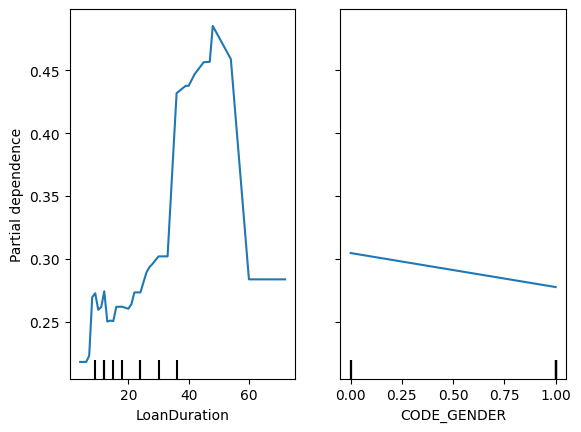

In [57]:
features = ["LoanDuration", "CODE_GENDER"]
PartialDependenceDisplay.from_estimator(xg, X, features)

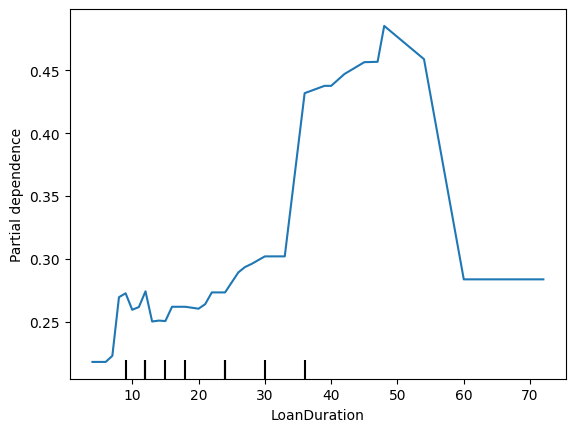

In [58]:
features = ["LoanDuration"]
PartialDependenceDisplay.from_estimator(xg, X, features)

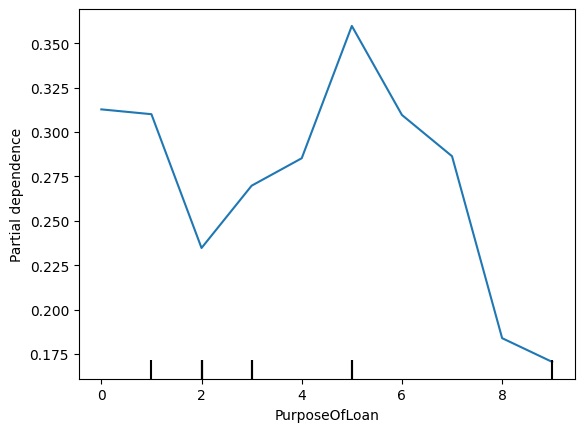

In [59]:
features = ["PurposeOfLoan"]
PartialDependenceDisplay.from_estimator(xg, X, features)

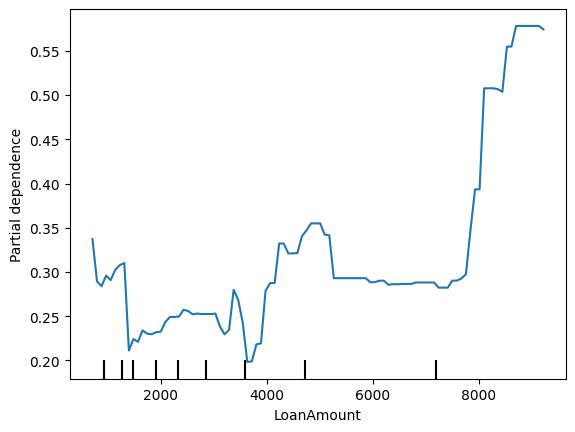

In [60]:
features = ["LoanAmount"]
PartialDependenceDisplay.from_estimator(xg, X, features)

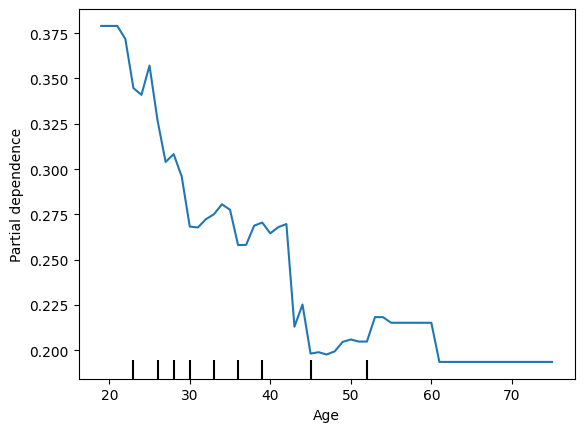

In [61]:
features = ["Age"]
PartialDependenceDisplay.from_estimator(xg, X, features)

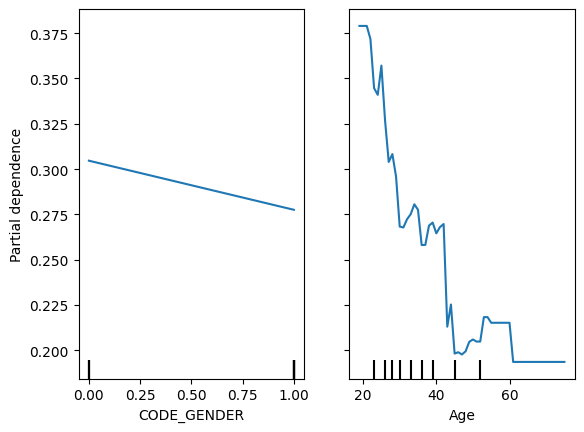

In [62]:
features = ["CODE_GENDER", "Age"]
PartialDependenceDisplay.from_estimator(xg, X, features)

#### It is analyzed that as the loan value increases, the greater the chance that the learning model will detect a "Bad Costumer". A man is more likely to be detected by the learning model as a "Good Costumer", as is an older person.

In [63]:
results = partial_dependence(xg, X, ["Age"])
results

{'grid_values': [array([19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
         53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70,
         74, 75])],
 'values': [array([19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
         53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70,
         74, 75])],
 'average': array([[0.37897876, 0.37897876, 0.37897876, 0.37177894, 0.34467345,
         0.34097302, 0.35710582, 0.32676896, 0.3039484 , 0.30828443,
         0.29589677, 0.26831603, 0.2678028 , 0.27234647, 0.27513346,
         0.28060418, 0.27756774, 0.25811866, 0.2582208 , 0.26883793,
         0.27051985, 0.2645898 , 0.26802093, 0.26972023, 0.21311773,
         0.22532955, 0.1982636 , 0.1990168 , 0.19777158, 0.1995013 ,
         0.2047443 , 0.20604159, 0.20489338, 0.2

In [64]:
def format_results(result_PDP):
    delimiter = "hjh,"
    return delimiter.join(str(element) for element in result_PDP)

In [65]:
print(format_results(results["values"]))

[19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42
 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66
 67 68 70 74 75]


In [66]:
print(format_result(results["average"]))

[0.37897876 0.37897876 0.37897876 0.37177894 0.34467345 0.34097302
 0.35710582 0.32676896 0.3039484  0.30828443 0.29589677 0.26831603
 0.2678028  0.27234647 0.27513346 0.28060418 0.27756774 0.25811866
 0.2582208  0.26883793 0.27051985 0.2645898  0.26802093 0.26972023
 0.21311773 0.22532955 0.1982636  0.1990168  0.19777158 0.1995013
 0.2047443  0.20604159 0.20489338 0.20489338 0.21837592 0.21837592
 0.21525928 0.21525928 0.21525928 0.21525928 0.21525928 0.21525928
 0.19366688 0.19366688 0.19366688 0.19366688 0.19366688 0.19366688
 0.19366688 0.19366688 0.19366688 0.19366688 0.19366688]


In [67]:
results["values"][0].tolist()

[19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 70,
 74,
 75]

In [68]:
results["average"].tolist()[0]

[0.37897875905036926,
 0.37897875905036926,
 0.37897875905036926,
 0.3717789351940155,
 0.3446734547615051,
 0.34097301959991455,
 0.3571058213710785,
 0.3267689645290375,
 0.30394840240478516,
 0.3082844316959381,
 0.2958967685699463,
 0.26831603050231934,
 0.26780280470848083,
 0.27234646677970886,
 0.2751334607601166,
 0.28060418367385864,
 0.2775677442550659,
 0.2581186592578888,
 0.2582207918167114,
 0.26883792877197266,
 0.27051985263824463,
 0.264589786529541,
 0.2680209279060364,
 0.2697202265262604,
 0.21311773359775543,
 0.22532954812049866,
 0.19826360046863556,
 0.19901679456233978,
 0.1977715790271759,
 0.19950130581855774,
 0.20474429428577423,
 0.2060415893793106,
 0.20489338040351868,
 0.20489338040351868,
 0.21837592124938965,
 0.21837592124938965,
 0.21525928378105164,
 0.21525928378105164,
 0.21525928378105164,
 0.21525928378105164,
 0.21525928378105164,
 0.21525928378105164,
 0.19366687536239624,
 0.19366687536239624,
 0.19366687536239624,
 0.19366687536239624,
 0.1

In [69]:
tuple(zip(results["values"][0].tolist(), results["average"].tolist()[0]))

((19, 0.37897875905036926),
 (20, 0.37897875905036926),
 (21, 0.37897875905036926),
 (22, 0.3717789351940155),
 (23, 0.3446734547615051),
 (24, 0.34097301959991455),
 (25, 0.3571058213710785),
 (26, 0.3267689645290375),
 (27, 0.30394840240478516),
 (28, 0.3082844316959381),
 (29, 0.2958967685699463),
 (30, 0.26831603050231934),
 (31, 0.26780280470848083),
 (32, 0.27234646677970886),
 (33, 0.2751334607601166),
 (34, 0.28060418367385864),
 (35, 0.2775677442550659),
 (36, 0.2581186592578888),
 (37, 0.2582207918167114),
 (38, 0.26883792877197266),
 (39, 0.27051985263824463),
 (40, 0.264589786529541),
 (41, 0.2680209279060364),
 (42, 0.2697202265262604),
 (43, 0.21311773359775543),
 (44, 0.22532954812049866),
 (45, 0.19826360046863556),
 (46, 0.19901679456233978),
 (47, 0.1977715790271759),
 (48, 0.19950130581855774),
 (49, 0.20474429428577423),
 (50, 0.2060415893793106),
 (51, 0.20489338040351868),
 (52, 0.20489338040351868),
 (53, 0.21837592124938965),
 (54, 0.21837592124938965),
 (55, 0.

In [70]:
lista_A = format_result(results["average"]).to
lista_B = format_results(results["values"])
tupla = tuple(zip(lista_A, lista_B))
print(tupla)

AttributeError: 'str' object has no attribute 'to'

In [ ]:
lista_A = [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 74, 75]
lista_B = [0.37897876, 0.37897876, 0.37897876, 0.37177894, 0.34467345, 0.34097302, 0.35710582, 0.32676896, 0.30394843, 0.30828443, 0.29589677, 0.26831603, 0.2678028 , 0.27234647, 0.27513346,0.28060418, 0.27756774, 0.25811866, 0.25822076, 0.26883793,0.27051985, 0.2645898 , 0.26802093, 0.26972023, 0.21311773,0.22532953, 0.1982636 , 0.1990168 , 0.19777158, 0.19950129,0.20474428, 0.20604159, 0.20489338, 0.20489338, 0.21837592,0.21837592, 0.21525928, 0.21525928, 0.21525928, 0.21525928,0.21525928, 0.21525928, 0.19366686, 0.19366686, 0.19366686,0.19366686, 0.19366686, 0.19366686, 0.19366686, 0.19366686,0.19366686, 0.19366686, 0.19366686]
tupla = tuple(zip(lista_A, lista_B))
print(tupla)

# Shap

### Used to explain how each feature affects the model, and allows local and global analysis for the dataset and problem at hand.


In [ ]:
import shap

# Fits the explainer
explainer = shap.Explainer(xg.predict, x_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(x_test)

##### The .data attribute is simply a copy of the input data, .base_values is the expected value of the target, or the average target value of all the train data, and .values are the SHAP values for each example.

In [ ]:
# Evaluate SHAP values

shap_values = explainer.shap_values(x_test)

In [ ]:
shap_values.shape

##### If we simply want the feature importances as determined by SHAP algorithm, we need to take the mean average value for each feature.

In [ ]:
from scipy.special import softmax
def print_feature_importances_shap_values(shap_values, features):
    #Prints the feature importances based on SHAP values in an ordered way
    #shap_values -> The SHAP values calculated from a shap.Explainer object
    #features -> The name of the features, on the order presented to the explainer
    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
        # Calculates the normalized version
        importances_norm = softmax(importances)
        # Organize the importances and columns in a dictionary
        feature_importances = {fea: imp for imp, fea in zip(importances, features)}
        feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
        # Sorts the dictionary
        feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
        feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
        # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")

In [ ]:
features = ['CODE_GENDER', 'ForeignWorker', 'Single', 'Age', 'LoanDuration',
       'PurposeOfLoan', 'LoanAmount', 'LoanRateAsPercentOfIncome',
       'YearsAtCurrentHome', 'NumberOfOtherLoansAtBank',
       'NumberOfLiableIndividuals', 'HasTelephone',
       'CheckingAccountBalance_geq_0', 'CheckingAccountBalance_geq_200',
       'SavingsAccountBalance_geq_100', 'SavingsAccountBalance_geq_500',
       'MissedPayments', 'NoCurrentLoan', 'CriticalAccountOrLoansElsewhere',
       'OtherLoansAtBank', 'OtherLoansAtStore', 'HasCoapplicant',
       'HasGuarantor', 'OwnsHouse', 'RentsHouse', 'Unemployed',
       'YearsAtCurrentJob_lt_1', 'YearsAtCurrentJob_geq_4',
       'JobClassIsSkilled']

In [ ]:
shap_values = explainer(x_test)
print_feature_importances_shap_values(shap_values=shap_values, features=features)

### Global Bar Plot

In [ ]:
shap.plots.bar(shap_values, 30)

##### Here the features are ordered from the highest to the lowest effect on the prediction. It takes in account the absolute SHAP value, so it does not matter if the feature affects the prediction in a positive or negative way.

##### The absolute SHAP value shows us how much a single feature affected the prediction

##### Loan duration contributed the most, Purpuose of the loan the second one, Loan amount the third, and OtherLoansAtStore was the feature with the lowest contribution to the prediction.

In [ ]:
shap.summary_plot(shap_values)

In [ ]:
shap.plots.beeswarm(shap_values)

In [ ]:
shap.summary_plot(shap_values, plot_type='violin')

##### On the beeswarm the features are also ordered by their effect on prediction, but we can also see how higher and lower values of the feature will affect the result. All the little dots on the plot represent a single observation. The horizontal axis represents the SHAP value, while the color of the point shows us if that observation has a higher or a lower value, when compared to other observations. In this example, higher latitudes and longitudes have a negative impact on the prediction, while lower values have a positive impact.

### Local Bar Plot

##### For analysis of local, instance-wise effects, we can use the following plots on single observations (in the examples below I used shap_values[0]).

In [ ]:
shap.plots.bar(shap_values[99])

In [ ]:
shap.plots.waterfall(shap_values[0])

##### The waterfall plot has the same information, represented in a different manner. Here we can see how the sum of all the SHAP values equals the difference between the prediction f(x) and the expected value E[f(x)].

In [ ]:
explainer = shap.TreeExplainer(xg)
exp = explainer(X_train) # <-- here
print(type(exp))
shap.plots.waterfall(exp[0])

In [ ]:
shap.plots.bar(exp, 30)

### Dependence Plot

In [ ]:
x_test.columns

### Local Feature Importance

In [ ]:
x_test.iloc[1]

.values =
array([ 1.06797054e-01,  1.02094039e-02,  4.84796837e-02, -9.11921680e-01,
       -9.09719467e-02, -5.49507746e-03, -4.31415886e-01, -3.63638580e-01,
       -1.52997106e-01, -3.56746279e-02, -1.42013319e-02,  9.45352614e-02,
        2.45191697e-02, -1.93115920e-01,  6.66002184e-03,  4.46265861e-02,
        1.74740311e-02, -4.72307764e-02,  1.51873723e-01, -2.64677871e-02,
        0.00000000e+00, -7.89401308e-03,  2.02763919e-02, -2.07115039e-01,
       -5.17190620e-02,  4.81320079e-04,  2.49683902e-01,  1.15801938e-01,
        7.51140192e-02], dtype=float32)

.base_values =
-0.85900635

.data =
array([   0,    0,    0,   45,   18,    3, 3049,    1,    1,    1,    1,
          0,    1,    1,    0,    0,    1,    0,    0,    0,    0,    0,
          0,    1,    0,    0,    1,    0,    0])


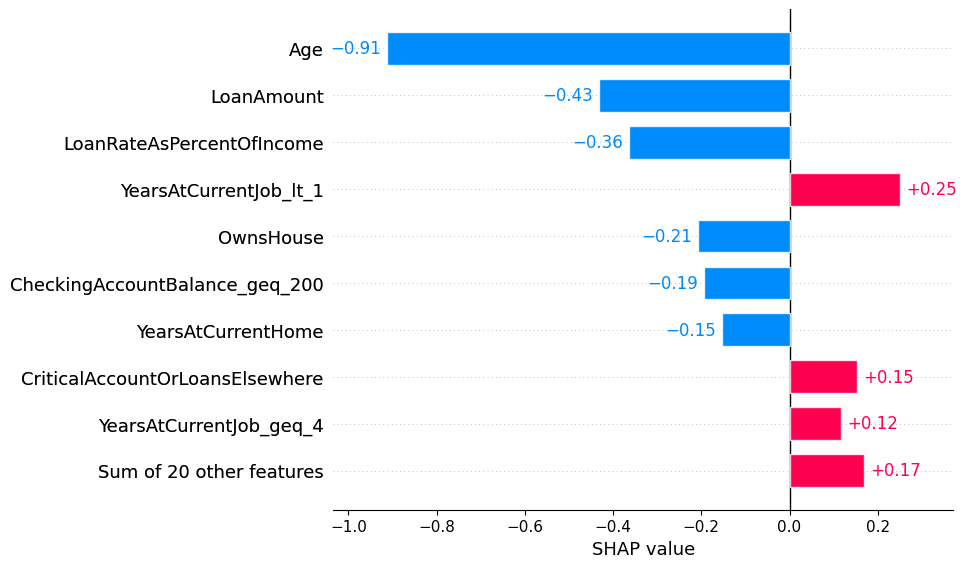

In [73]:
import shap
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)

shap.initjs()

explainer = shap.Explainer(xg)
shap_values = explainer(X_train)
print(shap_values[2])
plot =shap.plots.bar(shap_values[2])

In [ ]:
shap_values[2]

In [74]:
binary_explainer = shap.TreeExplainer(xg)
binary_shap_values = binary_explainer.shap_values(X_train)

In [75]:

def shap_force(clf, clf_step_name, index, 
               X_train_df, y_train,
               explainer, shap_vals):
  
    """Takes in a fitted classifier Pipeline, the name of the classifier step,
        the X training DataFrame, the y train array, a shap explainer, and the
        shap values to print the ground truth and predicted label and display
        the shap force plot for the record specified by index.
    Args:
        clf (estimator): An sklearn Pipeline with a fitted classifier as the final step.
        clf_step_name (str): The name given to the classifier step of the pipe.
        X_train_df (DataFrame): A Pandas DataFrame from the train-test-split
            used to train the classifier, with column names corresponding to
            the feature names.
        y_train (series or array): Subset of y data used for training.
        index (int): The index of the observation of interest.
        explainer (shap explainer): A fitted shap.TreeExplainer object.
        shap_vals (array): The array of shap values.
    Returns:
        Figure: Shap force plot showing the breakdown of how the model made
            its prediction for the specified record in the training set.
    """    
    
    
    ## Store model prediction and ground truth label
    pred = y_pred[index]
    true_label = y_train.iloc[index]
    
    
    ## Assess accuracy of prediction
    if true_label == pred:
        accurate = 'Correct!'
    else:
        accurate = 'Incorrect'
    
    
    ## Print output that checks model's prediction against true label
    print('***'*12)
    # Print ground truth label for row at index
    print(f'Ground Truth Label: {true_label}')
    print()
    # Print model prediction for row at index
    print(f'Model Prediction:  {pred} -- {accurate}')
    print('***'*12)
    print()
    
    
    ## Plot the prediction's explanation
    fig = shap.force_plot(explainer.expected_value,
                              shap_vals[index,:],
                              X_train_df.iloc[index,:])
    plt.savefig('temp.png')
    plt.close()
    return fig
    

In [76]:
## Print model prediction, true label, and shap force plot for third row
  ## of training set
shap_force(xg, 
           'xgb', # name of fitted classifier step in pipeline
           2, X_train, y_train, 
           binary_explainer, 
           binary_shap_values)

************************************
Ground Truth Label: 0

Model Prediction:  0 -- Correct!
************************************



In [77]:
explainer = shap.Explainer(xg)
shap_values = explainer.shap_values(X_train)
explainer.expected_value

-0.85900635

In [ ]:
def print_feature_importance(index, number_of_features):
    # Sort features based on importance scores
    sorted_features = X_train.columns[np.argsort(abs(shap_values.values[index]))[::-1]]
    sorted_shap_values = np.argsort(abs(shap_values.values[599]))[::-1]
    for i in range (sorted_features[:number_of_features].shape[0]):
        print(f"{sorted_features[i]}: {shap_values.values[index][sorted_shap_values[i]]}")

In [ ]:
def feature_importance(index, number_of_features):
    mes = ""
    # Sort features based on importance scores
    sorted_features = X_train.columns[np.argsort(abs(shap_values.values[index]))[::-1]]
    sorted_shap_values = np.argsort(abs(shap_values.values[599]))[::-1]
    for i in range (sorted_features[:number_of_features].shape[0]):
        mes += f"{sorted_features[i]}: {shap_values.values[index][sorted_shap_values[i]]}, "
    return mes, sorted_shap_values

In [ ]:
import shap
client_index = 2
 
df = pd.read_csv("/Users/larissaokabayashi/Documents/IC/NotebooksCredit/german_raw.csv",delimiter=',')   
df_encoder = df.copy()
# -1 mal pagador
df_encoder.rename(columns={'GoodCustomer':'TARGET','Gender':'CODE_GENDER'},inplace=True)
target_column_name = 'TARGET'
sensitive_column_name = 'CODE_GENDER'
pos_label = 0
df_encoder.TARGET = list(map(lambda x: 1 if x == -1 else  0 ,df_encoder.TARGET))
cat_cols = df_encoder.loc[:,(df_encoder.dtypes == object).values].columns # selecionadas apenas Gender e PurposeOfLoan
from sklearn.preprocessing import LabelEncoder
# Male == 1/ Female == 0
# 'Electronics' = 2, 'Education' = 1, 'Furniture' = 3, 'NewCar' = 5, 'UsedCar' = 9, 'Business' = 0, 'HomeAppliances' = 4, 'Repairs' = 7, 'Other' = 6, 'Retraining'= 8
label_encoder = LabelEncoder()
for col in cat_cols:
    df_encoder[col] = label_encoder.fit_transform(df_encoder[col])
X, y = df_encoder.drop(columns=[target_column_name]),df_encoder[target_column_name]
X_train, x_aux, y_train, y_aux = train_test_split(X, y, random_state=42,test_size=0.4)

study_dict = {'learning_rate': 0.08730015238141663, 'max_depth': 8, 'subsample': 0.9885334531348575, 
            'colsample_bytree': 0.8860893884596323, 'gamma': 0.38560298254941716, 
            'reg_alpha': 0.44299387597591205, 'reg_lambda': 0.37110498550700155, 
            'min_child_weight': 0.9339053330213946}

xg = xgb.XGBClassifier(learning_rate = study_dict['learning_rate'],max_depth = study_dict['max_depth'],
                            subsample = study_dict['subsample'],colsample_bytree = study_dict['colsample_bytree'],
                            gamma = study_dict['gamma'],
                            reg_lambda = study_dict['reg_lambda'],min_child_weight = study_dict['min_child_weight'],
                            random_state= 42)
xg.fit(X_train,y_train)

# SHAP
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(xg)
shap_values = explainer(X_train)
mes = ""
sorted_feature_indices = np.argsort(abs(shap_values.values[int(client_index)]))[::-1]
sorted_features = X_train.columns[sorted_feature_indices]
for i in range (0,sorted_feature_indices.shape[0]):
    mes += f"{sorted_features[i]}: {shap_values.values[int(client_index)][sorted_feature_indices[i]]}, "
print(mes)

Age: -0.9119216799736023, LoanAmount: -0.4314158856868744, LoanRateAsPercentOfIncome: -0.36363857984542847, YearsAtCurrentJob_lt_1: 0.2496839016675949, OwnsHouse: -0.207115039229393, CheckingAccountBalance_geq_200: -0.19311591982841492, YearsAtCurrentHome: -0.15299710631370544, CriticalAccountOrLoansElsewhere: 0.15187372267246246, YearsAtCurrentJob_geq_4: 0.11580193787813187, CODE_GENDER: 0.10679705440998077, HasTelephone: 0.09453526139259338, LoanDuration: -0.0909719467163086, JobClassIsSkilled: 0.07511401921510696, RentsHouse: -0.0517190620303154, Single: 0.04847968369722366, NoCurrentLoan: -0.04723077639937401, SavingsAccountBalance_geq_500: 0.04462658613920212, NumberOfOtherLoansAtBank: -0.035674627870321274, OtherLoansAtBank: -0.026467787101864815, CheckingAccountBalance_geq_0: 0.024519169703125954, HasGuarantor: 0.020276391878724098, MissedPayments: 0.017474031075835228, NumberOfLiableIndividuals: -0.0142013318836689, ForeignWorker: 0.010209403932094574, HasCoapplicant: -0.007894

In [ ]:
mes, sorted = feature_importance(2, 29)
mes

In [ ]:
int('2')

In [ ]:
sorted.shape[0]

In [ ]:
sorted